<a href="https://colab.research.google.com/github/OscarRojasG/OCR/blob/main/OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

The dataset contains 26 folders (A-Z) containing handwritten images in size 28x28 pixels, each alphabet in the image is centre fitted to 20x20 pixel box.

Each image is stored as Gray-level

https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format/

## Cargar dataset completo

No recomendable... se agota la RAM de colab y tarda demasiado en cargar.

Se recomienda reducir el volumen del dataset (revisar sección "Exportar").

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("A_Z Handwritten Data.csv", header=None, dtype=np.uint8, nrows=10000)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Cargar muestra

In [21]:
import pandas as pd
import numpy as np

df = pd.read_csv("sample.csv", dtype=np.uint8, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0,0,0,0,0,0,0,0,0,0,...,0,98,255,233,31,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,77,135,27,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,68,161,101,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,166,183,31,0


In [22]:
from PIL import Image as Img

pixels = df.iloc[0].to_numpy()[1:]
pixels = np.reshape(pixels, (20, 20))

img = Img.fromarray(pixels)
img

In [23]:
from io import BytesIO
from IPython.display import display, Image

def draw_image(pixel_arr, width, height):
    pixels = np.reshape(pixel_arr, (height, width))
    img = Img.fromarray(pixels)

    bio = BytesIO()
    img.save(bio, format='jpeg')
    return display(Image(bio.getvalue(), format='jpeg'))

## Exportar

Funciones para exportar dataset con 1000 filas por clase.

In [ ]:
letters = np.zeros(shape=(26, 1000, 785))

In [ ]:
# Asegurarse que todas las clases tengan 1000 datos como mínimo
df.iloc[:, 0].value_counts()

0     1000
1     1000
24    1000
23    1000
22    1000
21    1000
20    1000
19    1000
18    1000
17    1000
16    1000
15    1000
14    1000
13    1000
12    1000
11    1000
10    1000
9     1000
8     1000
7     1000
6     1000
5     1000
4     1000
3     1000
2     1000
25    1000
Name: 0, dtype: int64

In [ ]:
for letter in range(26):
    arr = df[df.iloc[:, 0] == letter].to_numpy()
    arr = arr[:1000]
    letters[letter] = arr

In [ ]:
flt_arr = letters.reshape(26000, 785)
np.savetxt("sample.csv", flt_arr.astype(int), fmt='%i', delimiter=",")

## Aplicar bounding box a dataset

In [ ]:
out_box_cols = []

for i in range(1, 785):
    x = (i-1) % 28
    y = (i-1) // 28

    # Pixeles fuera del centro de 20x20
    if x < 4 or x > 23 or y < 4 or y > 23:
        out_box_cols.append(i)

In [ ]:
sum = 0

# Casillas no negras fuera del centro
for col in out_box_cols:
    sum += 26000 - df.iloc[:, col].value_counts()[0]

sum

885

Vemos que existe algo de ruido en las imágenes, pero si eliminamos estas casillas no debería afectar mucho...

In [ ]:
# 28x28 - 20x20
len(out_box_cols)

384

In [ ]:
df_box = df.drop(df.columns[out_box_cols], axis=1)

In [ ]:
pixels = df_box.iloc[0].to_numpy()[1:]
pixels = np.reshape(pixels, (20, 20))

img = Img.fromarray(pixels)
img

In [ ]:
df_box_arr = df_box.to_numpy()
np.savetxt("sample.csv", df_box_arr.astype(int), fmt='%i', delimiter=",")

# Modelo

In [24]:
from sklearn.model_selection import train_test_split

Y = df.iloc[:, 0].values
X = df.iloc[:, 1:].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

Creación del modelo

In [25]:
from keras import models
from keras import layers

model = models.Sequential()

model.add(layers.Dense(100, activation='sigmoid', input_shape=(400,)))
model.add(layers.Dense(26, activation='sigmoid'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Entrenamiento

In [26]:
model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
650/650 [==============================] - 2s 2ms/step - loss: 1.9628 - accuracy: 0.5135
Epoch 2/100
650/650 [==============================] - 1s 2ms/step - loss: 1.0947 - accuracy: 0.7276
Epoch 3/100
650/650 [==============================] - 1s 2ms/step - loss: 0.8810 - accuracy: 0.7643
Epoch 4/100
650/650 [==============================] - 1s 2ms/step - loss: 0.7988 - accuracy: 0.7816
Epoch 5/100
650/650 [==============================] - 1s 2ms/step - loss: 0.7493 - accuracy: 0.7925
Epoch 6/100
650/650 [==============================] - 2s 3ms/step - loss: 0.7470 - accuracy: 0.7894
Epoch 7/100
650/650 [==============================] - 1s 2ms/step - loss: 0.7149 - accuracy: 0.8003
Epoch 8/100
650/650 [==============================] - 1s 2ms/step - loss: 0.6693 - accuracy: 0.8093
Epoch 9/100
650/650 [==============================] - 1s 2ms/step - loss: 0.6664 - accuracy: 0.8091
Epoch 10/100
650/650 [==============================] - 1s 2ms/step - loss: 0.6454 - accura

Validación con datos de prueba: entropía categórica - accuracy

In [ ]:
model.evaluate(X_test, Y_test, verbose=False)

[0.4340173304080963, 0.8786538243293762]

In [82]:
def predict(image_arr, verbose=False):
    prob = model.predict(np.array([image_arr]))
    pred = prob.argmax()
    letter = chr(ord('A') + pred)

    if verbose:
        print(letter)
        draw_image(image_arr, 20, 20)

    return letter

In [83]:
for i in range(10):
    letter = predict(X_test[i], verbose=True)

1/1 [==============================] - 0s 19ms/step
Q


1/1 [==============================] - 0s 21ms/step
U


1/1 [==============================] - 0s 22ms/step
M


1/1 [==============================] - 0s 20ms/step
A


1/1 [==============================] - 0s 23ms/step
U


1/1 [==============================] - 0s 24ms/step
Q


1/1 [==============================] - 0s 19ms/step
S


1/1 [==============================] - 0s 20ms/step
K


1/1 [==============================] - 0s 19ms/step
D


1/1 [==============================] - 0s 26ms/step
E


# Procesamiento de imágenes

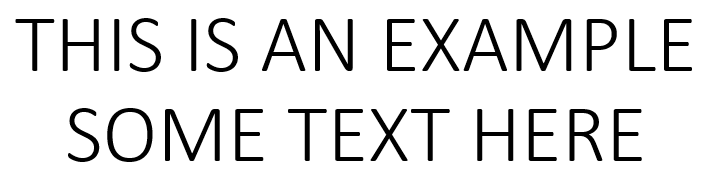

In [ ]:
import cv2

img = cv2.imread('example.png')
img.astype("uint8")
Img.fromarray(img)

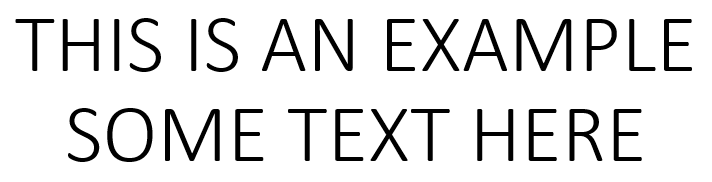

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
Img.fromarray(gray)

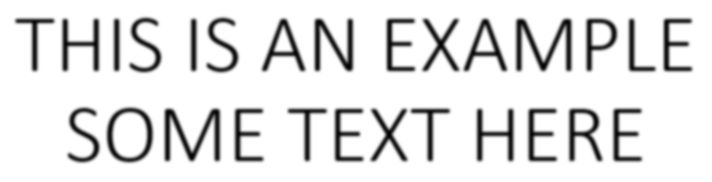

In [ ]:
blur = cv2.GaussianBlur(gray, (7,7), 0)
Img.fromarray(blur)

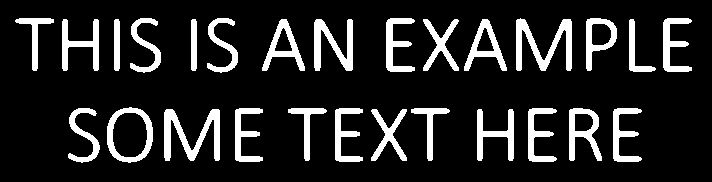

In [ ]:
image_contour = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
Img.fromarray(image_contour)

In [ ]:
# Mapa para guardar contornos
contours = dict()

image_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1))
image_dilate = cv2.dilate(image_contour, image_kernel, iterations=5)

# Obtener líneas
lines = cv2.findContours(image_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
lines = lines[0]

# Procesar cada línea
for l, line in enumerate(lines):
    contours[l] = dict()
    contours[l]['cntr'] = line
    contours[l]['words'] = dict()

    x, y, w, h = cv2.boundingRect(line)
    line_contour = image_contour[y:y+h, x:x+w]

    line_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
    line_dilate = cv2.dilate(line_contour, line_kernel, iterations=5)

    # Obtener palabras
    words = cv2.findContours(line_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    words = words[0]

    # Procesar cada palabra
    for w, word in enumerate(words):
        contours[l]['words'][w] = dict()
        contours[l]['words'][w]['cntr'] = word
        contours[l]['words'][w]['letters'] = dict()

        xw, yw, ww, hw = cv2.boundingRect(word)
        word_contour = line_contour[yw:yw+hw, xw:xw+ww]

        # Obtener letras
        letters = cv2.findContours(word_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        letters = letters[0]

        # Guardar cada letra en el mapa
        for c, letter in enumerate(letters):
            contours[l]['words'][w]['letters'][c] = dict()
            contours[l]['words'][w]['letters'][c]['cntr'] = letter

Imagen solo con propósitos ilustrativos...

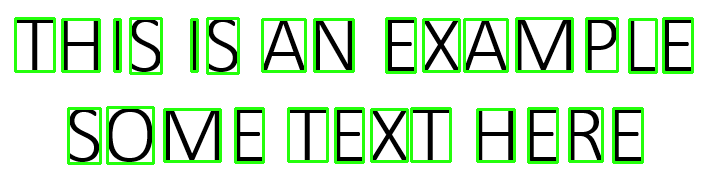

In [ ]:
img2 = img.copy()

for line in contours:
    x, y, w, h = cv2.boundingRect(contours[line]['cntr'])

    for word in contours[line]['words']:
        xw, yw, ww, hw = cv2.boundingRect(contours[line]['words'][word]['cntr'])

        for letter in contours[line]['words'][word]['letters']:
            xc, yc, wc, hc = cv2.boundingRect(contours[line]['words'][word]['letters'][letter]['cntr'])
            cv2.rectangle(img2, (x+xw+xc,y+yw+yc), (x+xw+xc+wc, y+yw+yc+hc), (36,255,12), 2)

Img.fromarray(img2)

Predecir letras en orden

In [ ]:
text = ""

# Ordenar líneas de arriba a abajo
lines = sorted(contours.keys(),
               key=lambda x: cv2.boundingRect(contours[x]['cntr'])[1])

for line in lines:
    # Dimensiones de la línea respecto a la imagen
    x, y, w, h = cv2.boundingRect(contours[line]['cntr'])

    # Ordenar palabras de izquierda a derecha
    words = sorted(contours[line]['words'].keys(),
                   key=lambda x: cv2.boundingRect(contours[line]['words'][x]['cntr'])[0])

    for word in words:
        # Dimensiones de la palabra respecto a la línea
        xw, yw, ww, hw = cv2.boundingRect(contours[line]['words'][word]['cntr'])

        # Ordenar letras de izquierda a derecha
        letters = sorted(contours[line]['words'][word]['letters'].keys(),
                         key=lambda x: cv2.boundingRect(contours[line]['words'][word]['letters'][x]['cntr'])[0])

        for letter in letters:
            # Dimensiones de la letra respecto a la palabra
            xc, yc, wc, hc = cv2.boundingRect(contours[line]['words'][word]['letters'][letter]['cntr'])

            # Dimensiones de la letra respecto a la imagen
            letter_img = image_contour[y+yw+yc:y+yw+yc+hc, x+xw+xc:x+xw+xc+wc]

            # Redimensionar letra
            resized = cv2.resize(letter_img, (20,20))

            # Convertir matriz a arreglo
            image_arr = np.ravel(resized)

            # Predecir letra
            letter = predict(image_arr, verbose=True)
            text += letter

        text += " "

    text += "\n"

1/1 [==============================] - 0s 53ms/step
I


1/1 [==============================] - 0s 38ms/step
H


1/1 [==============================] - 0s 54ms/step
B


1/1 [==============================] - 0s 34ms/step
S


1/1 [==============================] - 0s 34ms/step
B


1/1 [==============================] - 0s 22ms/step
S


1/1 [==============================] - 0s 27ms/step
A


1/1 [==============================] - 0s 21ms/step
N


1/1 [==============================] - 0s 24ms/step
E


1/1 [==============================] - 0s 23ms/step
X


1/1 [==============================] - 0s 24ms/step
A


1/1 [==============================] - 0s 30ms/step
V


1/1 [==============================] - 0s 27ms/step
P


1/1 [==============================] - 0s 23ms/step
L


1/1 [==============================] - 0s 22ms/step
E


1/1 [==============================] - 0s 21ms/step
S


1/1 [==============================] - 0s 22ms/step
Q


1/1 [==============================] - 0s 23ms/step
V


1/1 [==============================] - 0s 30ms/step
E


1/1 [==============================] - 0s 22ms/step
T


1/1 [==============================] - 0s 22ms/step
E


1/1 [==============================] - 0s 21ms/step
X


1/1 [==============================] - 0s 24ms/step
T


1/1 [==============================] - 0s 23ms/step
H


1/1 [==============================] - 0s 25ms/step
E


1/1 [==============================] - 0s 26ms/step
R


1/1 [==============================] - 0s 26ms/step
E


In [ ]:
print(text)

IHBS BS AN EXAVPLE 
SQVE TEXT HERE 



# Ejemplos

In [19]:
import cv2
import numpy as np

In [94]:
def preprocessing_image(filename):
    # Leer archivo
    img = cv2.imread(filename)
    img.astype("uint8")

    # Difuminar, pasar a blanco y negro
    preimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    preimg = cv2.GaussianBlur(preimg, (7,7), 0)
    preimg = cv2.threshold(preimg, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    return img, preimg

In [95]:
def get_contours(image_contour):
    # Mapa para guardar contornos
    contours = dict()

    image_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1))
    image_dilate = cv2.dilate(image_contour, image_kernel, iterations=5)

    # Obtener líneas
    lines = cv2.findContours(image_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    lines = lines[0]

    # Procesar cada línea
    for l, line in enumerate(lines):
        contours[l] = dict()
        contours[l]['cntr'] = line
        contours[l]['words'] = dict()

        x, y, w, h = cv2.boundingRect(line)
        line_contour = image_contour[y:y+h, x:x+w]

        line_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
        line_dilate = cv2.dilate(line_contour, line_kernel, iterations=5)

        # Obtener palabras
        words = cv2.findContours(line_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        words = words[0]

        # Procesar cada palabra
        for w, word in enumerate(words):
            contours[l]['words'][w] = dict()
            contours[l]['words'][w]['cntr'] = word
            contours[l]['words'][w]['letters'] = dict()

            xw, yw, ww, hw = cv2.boundingRect(word)
            word_contour = line_contour[yw:yw+hw, xw:xw+ww]

            # Obtener letras
            letters = cv2.findContours(word_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            letters = letters[0]

            # Guardar cada letra en el mapa
            for c, letter in enumerate(letters):
                contours[l]['words'][w]['letters'][c] = dict()
                contours[l]['words'][w]['letters'][c]['cntr'] = letter

    return contours

In [96]:
def model_predict(image_arr):
    prob = model.predict(np.array([image_arr]), verbose=0)
    pred = prob.argmax()
    letter = chr(ord('A') + pred)

    return letter

def predict_text(image, contours):
    text = ""

    # Ordenar líneas de arriba a abajo
    lines = sorted(contours.keys(),
                key=lambda x: cv2.boundingRect(contours[x]['cntr'])[1])

    for line in lines:
        # Dimensiones de la línea respecto a la imagen
        x, y, w, h = cv2.boundingRect(contours[line]['cntr'])

        # Ordenar palabras de izquierda a derecha
        words = sorted(contours[line]['words'].keys(),
                    key=lambda x: cv2.boundingRect(contours[line]['words'][x]['cntr'])[0])

        for word in words:
            # Dimensiones de la palabra respecto a la línea
            xw, yw, ww, hw = cv2.boundingRect(contours[line]['words'][word]['cntr'])

            # Ordenar letras de izquierda a derecha
            letters = sorted(contours[line]['words'][word]['letters'].keys(),
                            key=lambda x: cv2.boundingRect(contours[line]['words'][word]['letters'][x]['cntr'])[0])

            for letter in letters:
                # Dimensiones de la letra respecto a la palabra
                xc, yc, wc, hc = cv2.boundingRect(contours[line]['words'][word]['letters'][letter]['cntr'])

                # Dimensiones de la letra respecto a la imagen
                letter_img = image[y+yw+yc:y+yw+yc+hc, x+xw+xc:x+xw+xc+wc]

                # Redimensionar letra
                resized = cv2.resize(letter_img, (20,20))

                # Convertir matriz a arreglo
                image_arr = np.ravel(resized)

                # Predecir letra
                letter = model_predict(image_arr)
                text += letter

            text += " "

        text += "\n"

    return text

In [97]:
from io import BytesIO
from IPython.display import display, Image

def show_image(image):
    img = Img.fromarray(image)
    bio = BytesIO()
    img.save(bio, format='jpeg')
    return display(Image(bio.getvalue(), format='jpeg'))

In [98]:
def draw_contours(image, contours):
    img_lines = image.copy()
    img_words = image.copy()
    img_letters = image.copy()

    for line in contours.keys():
        # Dimensiones de la línea respecto a la imagen
        x, y, w, h = cv2.boundingRect(contours[line]['cntr'])

        # Dibujar linea
        cv2.rectangle(img_lines, (x,y), (x+w, y+h), (36,12,255), 3)

        for word in contours[line]['words'].keys():
            # Dimensiones de la palabra respecto a la línea
            xw, yw, ww, hw = cv2.boundingRect(contours[line]['words'][word]['cntr'])

            # Dibujar palabra
            cv2.rectangle(img_words, (x+xw,y+yw), (x+xw+ww, y+yw+hw), (255,36,12), 1)

            for letter in contours[line]['words'][word]['letters'].keys():
                # Dimensiones de la letra respecto a la palabra
                xc, yc, wc, hc = cv2.boundingRect(contours[line]['words'][word]['letters'][letter]['cntr'])

                cv2.rectangle(img_letters, (x+xw+xc,y+yw+yc), (x+xw+xc+wc, y+yw+yc+hc), (36,255,12), 2)

    show_image(img_lines)
    show_image(img_words)
    show_image(img_letters)

In [99]:
def get_text(filename, verbose=False):
    img, preimg = preprocessing_image(filename)
    contours = get_contours(preimg)
    if verbose: draw_contours(img, contours)
    text = predict_text(preimg, contours)

    return text

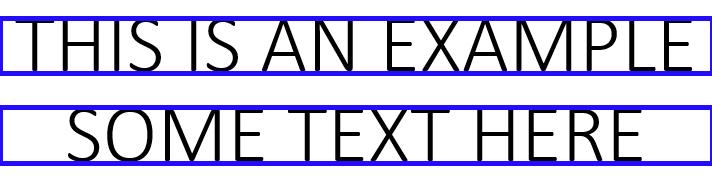

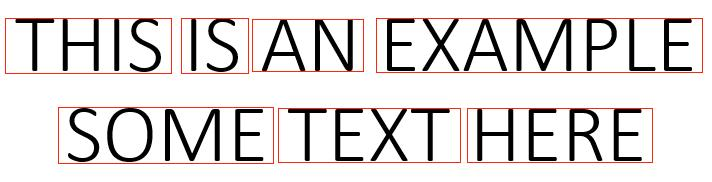

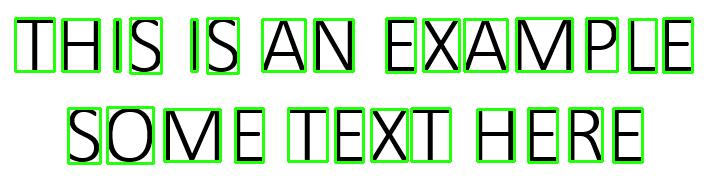

THBS BS AW EXAVPKE 
SOVE TEXT HERE 



In [100]:
text = get_text("example.png", True)
print(text)

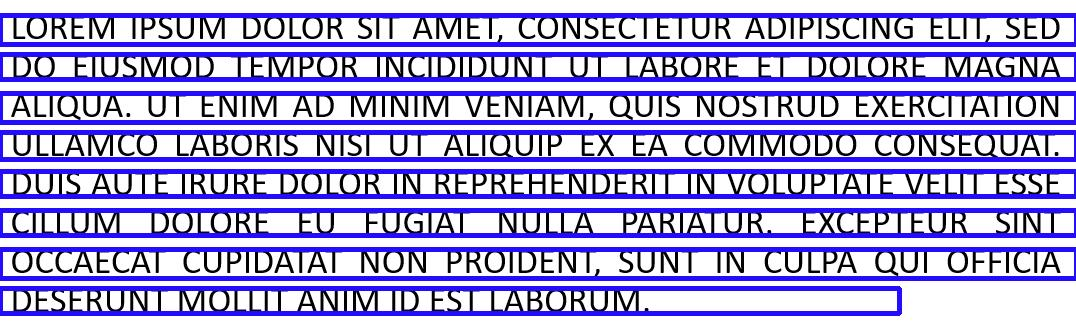

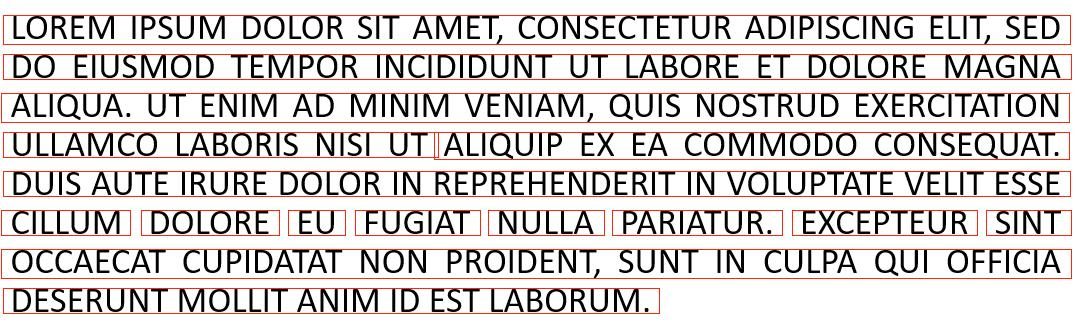

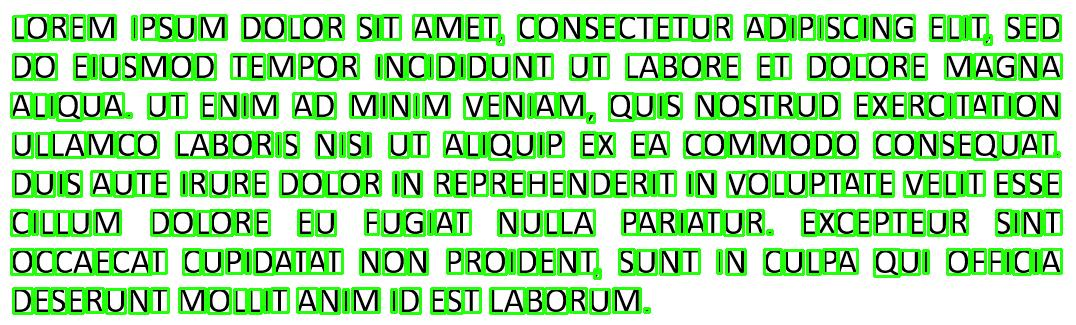

LOREUBPSUUDOLORSQTAUEIPCOWSEJETURADBPBSCQWGELBIPSED 
DOEQUSUODTEUFORBWCBDBDUNTUIZBOREETDOKOREUAGWA 
ALBQUABUIENBUADUBWBUVEWBAUPQUBSWOSTRUDEXERCBIAIBOW 
UKDUCODBORBSWBSQUT ALQQUBPEXEACOUUODOCOWSEQUATQ 
DUBSAUIEBRUREDOKORBWREPREHEWDERBTBWVOLUPIATEVELQTESSE 
CBKLUU DOKORE EU FUGBAT WULD PARBATURB EXCEFTEUR SQWI 
OCUEDTCUPBDAIATWOWPROBDEWTBSUWTBWCULPAQUBOFFBCQA 
DESERUWIUOLLBIANBUQDESTUBORUUQ 



In [93]:
text = get_text("image.png", True)
print(text)

# Más pruebas

In [ ]:
from collections import OrderedDict

def sort_contours(cts):
    tol = 20 # Desviación máxima en posición y promedio
    lines = OrderedDict()

    # Ordenar líneas
    for c in cts:
        x, y, w, h = cv2.boundingRect(c)

        y_mean = (y+y+h)/2
        added = False

        for key, value in lines.items():
            if abs(y_mean - key) < tol:
                lines[key].append(c)
                added = True
                break

        if added == False:
            lines[y_mean] = [c]

    sorted_cts = []

    # Ordenar de izquierda a derecha
    for key, value in lines.items():
        lines[key] = sorted(lines[key], key=lambda c: cv2.boundingRect(c)[0], reverse=True)

        # Juntar todos los contornos en un arreglo
        for c in lines[key]:
            sorted_cts.insert(0, c)

    return sorted_cts

In [ ]:
# Codigo comprimido

import cv2

def process_image(filename, show_image=False):
    # Leer imagen
    img = cv2.imread(filename)

    # Escala de grises, difuminar y ampliar bordes
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    edges = cv2.Canny(blur, 60, 80)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 13))
    dilate = cv2.dilate(edges, kernel, iterations=1)

    # Encontrar contornos
    contours = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0]

    # Eliminar contornos muy altos y anchos
    valid_cts = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if (w >= 15 and w <= 200) and (h >= 15 and h <= 200):
            valid_cts.append(c)

    # Ordenar contornos
    sorted_cts = sort_contours(valid_cts)

    # Encontrar letras
    letters = []
    for c in sorted_cts:
        x, y, w, h = cv2.boundingRect(c)
        box = gray[y:y+h, x:x+w]
        thresh = cv2.threshold(box, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        resized = cv2.resize(thresh, (20,20))
        image_arr = np.ravel(resized)
        letters.append(image_arr)

    # Mostrar imagen con contornos
    if show_image:
        for c in valid_cts:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(img, (x,y), (x+w, y+h), (36,255,12), 2)
        return letters, Img.fromarray(img)

    return letters, None

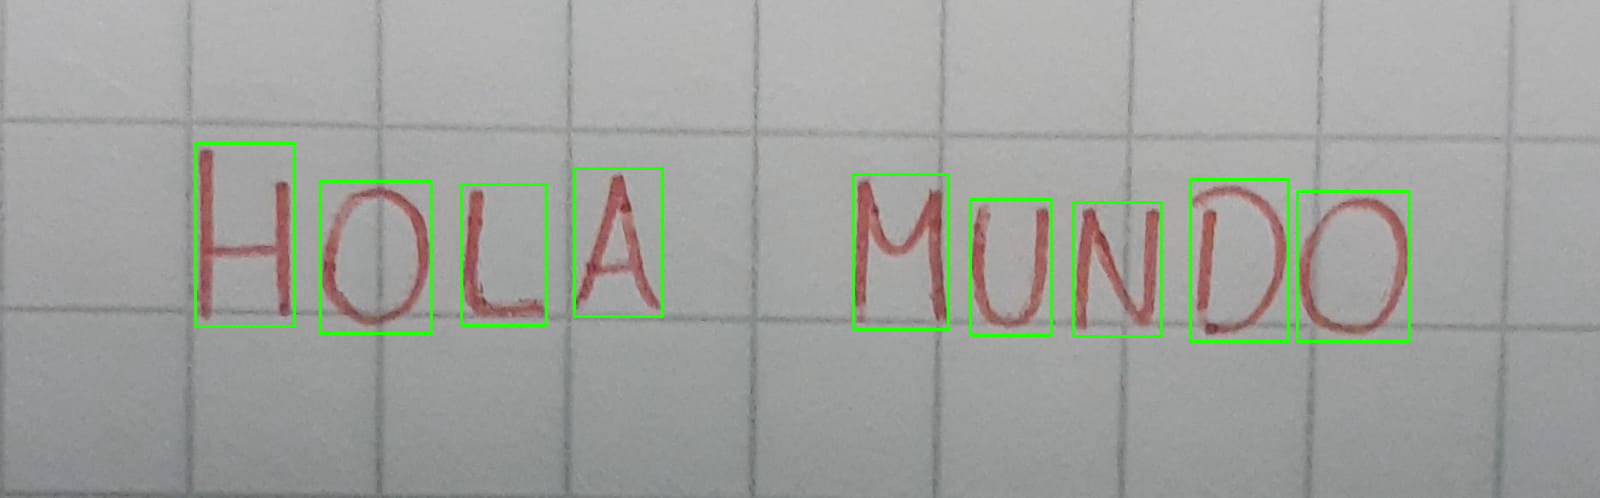

In [ ]:
letters, img = process_image('hola_mundo.jpeg', True)
img

In [ ]:
for i in range(len(letters)):
    predict(letters[i], True)

1/1 [==============================] - 0s 88ms/step
H


1/1 [==============================] - 0s 47ms/step
K


1/1 [==============================] - 0s 31ms/step
O


1/1 [==============================] - 0s 36ms/step
L


1/1 [==============================] - 0s 71ms/step
M


1/1 [==============================] - 0s 50ms/step
U


1/1 [==============================] - 0s 40ms/step
N


1/1 [==============================] - 0s 115ms/step
D


1/1 [==============================] - 0s 37ms/step
O
